<a href="https://colab.research.google.com/github/LazyTurtle/DL-Reidentification/blob/main/DL_Reidentification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup.

Preliminary imports

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import collections

import glob
import os
import pandas as pd
from PIL import Image
import shutil
import random
from math import ceil, sqrt
import numpy as np

Setting up the environment.

The only comunication from outside the runtime of colab is the loading of the dataset zip file. Everything else must be within colab runtime.

The only permissible global variables will be the variables containing important paths, to use as sparsingly as possible.

In [ ]:
DATASET_DRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/datasets/Market-1501.zip"

DATASET_PATH = "/content/Market-1501"
LOG_PATH_MARKET = "/content/logs/market/"
LOG_PATH_AGGREGATOR = "/content/logs/aggregator/"
LOG_DISTANCE_MEASUREMENT_AGGREGATOR = "/content/logs/aggregator/distance_measurement"

TRAIN_PATH = "/content/Market-1501/train"
TEST_PATH = "/content/Market-1501/test"
QUERIES_PATH = "/content/Market-1501/queries"
ANNOTATIONS_PATH = "/content/Market-1501/annotations_train.csv"

CLASSIFICATION_TEST_PATH = "/content/gdrive/My Drive/Colab Notebooks/datasets/classification_test.csv"
REID_TEST_PATH = "/content/gdrive/My Drive/Colab Notebooks/datasets/reid_test.txt"
LOAD_PATH_AGGREGATOR = "/content/gdrive/My Drive/Colab Notebooks/datasets/AGGREGATOR.pth"
SAVE_PATH_AGGREGATOR = "/content/gdrive/My Drive/Colab Notebooks/datasets/AGGREGATOR.pth"
SAVE_PATH_CLASSIFIER = "/content/gdrive/My Drive/Colab Notebooks/datasets/CLASSIFIER.pth"
LOAD_PATH_CLASSIFIER = "/content/gdrive/My Drive/Colab Notebooks/datasets/CLASSIFIER.pth"
OUTPUT_PATH = "/content/gdrive/My Drive/Colab Notebooks/datasets/"

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
except Exception as E:
  print("There has been a problem mounting google drive.")
  print(E)

!if [ ! -d "{DATASET_PATH}" ]; then unzip "{DATASET_DRIVE_PATH}" -d "{DATASET_PATH}"; else echo "Dataset already present";  fi
!if [ ! -d "{LOG_PATH_MARKET}" ]; then mkdir -p "{LOG_PATH_MARKET}"; else echo "Market classifier log dir already present"; fi
!if [ ! -d "{LOG_PATH_AGGREGATOR}" ]; then mkdir -p "{LOG_PATH_AGGREGATOR}"; else echo "Aggregator log dir already present"; fi

# Classification

## Classification Task: data preprocessing, organization and testing.

The dataset is initialized with the path of the annotations, the list of person ids to be included and possibly the
transformations to be applied.

When the network requests the function `__getitem()__` loads the correct image, applies the transformations (if given)
and calls the function `__handlelabels()__`, which checks the annotations file and returns a dictionary containing the
correct labels for a given person id. `__getitem__()` will then return a tuple containing the image and the dictionary.

The colors are not considered singularly, but only two variables are used: `upcolor` and `downcolor`. This ensures that
there is always a color. The multicolor case is simply handled as another color.

`upcolor`$\in \{0,1,2,3,4,5,6,7,8\}$

`downcolor`$\in \{0,1,2,3,4,5,6,7,8,9\}$

Check `MarketDataset.color_labels` for information on the correspondence between number and value.

As for the ids, both the true person id and a secondary id are stored. The first one allows to use the correct images
and labels, while the second one is due to PyTorch wanting a value in $\{0, ...\}$ and the real person id is full of
missing ids. The secondary id is computed by associating the row in annotations.csv to the correspondent person id.

Please except for the dataset, in all the other function with the network use `Net.labels` instead of
`Marketdataset.labels` since in the first one `person_id` is removed not to cause confusion.

In [ ]:
def get_identity(sample_path):
    """Extracts the person id from the file name.
    :param str sample_path: The file name.
    :return int: The person id from the file name.
    """
    id = int(sample_path.split('/')[-1].split('.')[0].split('_')[0])
    return id

def get_identities(samples_path="", files=[]):
  """Extracts a set of ids from a list of paths.
  :param str samples_path: The directory containing the images.
  :param list files: The list of file names.
  :return set: A set of ids.
  """
  assert (bool(samples_path!="") ^ bool(files!=[])), "One and only one of the two parameters must be set." 
  file_paths=files
  if samples_path!="":
    file_paths = sorted(glob.glob(os.path.join(samples_path,"*.jpg")))
  ids = set()
  for file_path in file_paths:
    ids.add(get_identity(file_path))
  return ids

class MarketDataset(torch.utils.data.Dataset):
  dataset_labels = [
    "age",
    "backpack",
    "bag",
    "handbag",
    "clothes",
    "down",
    "up",
    "hair",
    "hat",
    "gender",
    "upcolor",
    "downcolor"
  ]
  color_labels=[# Please keep this format since upgreen is used as separator between up and down colors.
    "upblack",
    "upwhite",
    "upred",
    "uppurple",
    "upyellow",
    "upgray",
    "upblue",
    "upgreen",
    "downblack",
    "downwhite",
    "downpink",
    "downpurple",
    "downyellow",
    "downgray",
    "downblue",
    "downgreen",
    "downbrown",
  ]# multicolors are handled separately in the functions. Please remember to handle these cases as well.
  """
  Given a list of ids, the dataset is initialized with the annotations, transformations and the list of images to be used.
  :param str annotations: The path to the file containing the annotations.
  :param list ids_list: The list of ids to include in the dataset.
  :param torchvision.transforms.transforms transforms: The transformations to be applied to the images.
  """
  

  def __init__(self, annotations, file_folder, ids_list, transforms=None, test = False):
    super(MarketDataset, self).__init__()
    self.annotations=pd.read_csv(annotations, index_col="id")
    self.annotations_index=self.annotations.index
    self.transforms=transforms
    self.ids_list=ids_list
    all_paths=sorted(glob.glob(os.path.join(file_folder, "*.jpg")))
    self.paths=list()
    for path in all_paths:
      person_id=get_identity(path)
      if person_id in self.ids_list:
        self.paths.append(path)
    self.test = test

  def __len__(self):
    """
    Returns the number of *images* in the dataset.
    :return int: The number of images in the dataset.
    """
    return len(self.paths)

  def __handlelabels__(self, person_id):
    """
    Given a person id, the function returns a dictionary containing the labels.
    :param int person_id: The person id.
    :return dict: A dictionary containing the labels.
    """
    ret=dict()
    for label in MarketDataset.dataset_labels:

      # both to remove after clarifications
      if label == "person_id":
        ret[label]=person_id

      elif label == "id":
        ret[label]=self.annotations_index.get_loc(person_id)

      elif "color" in label:
        ret[label]=-1
        if "up" in label:
            for lab in range(MarketDataset.color_labels.index("upgreen")):
                if self.annotations[MarketDataset.color_labels[lab]][person_id]==2:
                    ret[label]=lab
                    break
            if ret[label]==-1: #Multilabel case
              ret[label]=8
        elif "down" in label:
            for lab in range(MarketDataset.color_labels.index("upgreen"), len(MarketDataset.color_labels)):
                if self.annotations[MarketDataset.color_labels[lab]][person_id]==2:
                    ret[label]=lab-MarketDataset.color_labels.index("upgreen")-1
                    break
            if ret[label]==-1: #Multilabel case
              ret[label]=9
      else:
        ret[label]=int(self.annotations[label][person_id])-1
  
    return ret

  def __getitem__(self, item):
    """
    This function takes an id and returns a tuple containing the image and the dictionary of the labels.
    :param item: The id of the image.
    :return (torch.Tensor, dict): A tuple containing the image and a dictionary with the labels.
    """
    file_path=self.paths[item]
    image=Image.open(file_path)
    if self.transforms is not None:
      image=self.transforms(image)
    else:
      convert_tensor = T.ToTensor()
      image=convert_tensor(image)
    
    if self.test == False:
      person_id=get_identity(file_path)

      labels = self.__handlelabels__(person_id)
      person_id=self.annotations.index.get_loc(person_id)

      return image, labels
    else:
      path = str(file_path.split("/")[4])
      return image, path
  def get_predictions(output, path):
    """
    Returns a dictionary with the correctly formatted values
    :param dict output: The output obtained from the network.
    :param str path: The path of the analyzed image. 
    """
    pred_dict=dict()
    pred_dict["path"]=path
    for label in MarketClassifier.labels:
      _, pred=output[label].max(1)
      if "color" not in label:
        pred_dict[label]=int(pred.item())+1
      else:
        offset=0
        if "down" in label:
          offset=MarketDataset.color_labels.index("upgreen")+1
        multi_color=True
        for col_label in MarketDataset.color_labels:
          if ("up" in label and "up" in col_label) or \
              ("down" in label and "down" in col_label): #I want them to wither be both up or down
            if pred.item()==MarketDataset.color_labels.index(col_label)-offset:
              pred_dict[col_label]=2
              multi_color=False
            else:
              pred_dict[col_label]=1
        if "up" in label:
          pred_dict["upmulticolor"]=int(multi_color)+1
        elif "down" in label:
          pred_dict["downmulticolor"]=int(multi_color)+1
    return pred_dict

  def format_predictions(predictions, filename=""):
    """
    Formats the predictions.
    :param list predictions: The predictions
    :param str filename: If empty, the function prints to stdout, otherwise to file. 
    """
    if filename!="":
      with open(filename, "w+") as file:
        #Write header 
        file.write("path,")
        for label in MarketClassifier.labels:
          if "color" not in label:
            file.write(label+",")
          else:
            if "up" in label:
              for col_lab in MarketDataset.color_labels[:MarketDataset.color_labels.index("upgreen")]:
                file.write(col_lab+",")
            elif "down" in label:
              for col_lab in MarketDataset.color_labels[MarketDataset.color_labels.index("upgreen"):]:
                file.write(col_lab+",")
        file.write("upmulticolor,downmulticolor\n")
        #Write data
        for pred in predictions:
          file.write(pred["path"]+",")
          for label in MarketClassifier.labels:
            if "color" not in label:
              file.write(str(pred[label])+",")
            else:
              if "up" in label:
                for col_lab in MarketDataset.color_labels[:MarketDataset.color_labels.index("upgreen")]:
                  file.write(str(pred[col_lab])+",")
              elif "down" in label:
                for col_lab in MarketDataset.color_labels[MarketDataset.color_labels.index("upgreen"):]:
                  file.write(str(pred[col_lab])+",")
          file.write(str(pred["upmulticolor"])+",")
          file.write(str(pred["downmulticolor"])+"\n")
      #shutil.copy(filename, OUTPUT_FILE.split(".csv")[0]+"_latest.csv")
    else:
      for pred in predictions:
        print(pred["path"]+":")
        for label in MarketClassifier.labels:
          if "color" not in label:
            print((label+": "), pred[label])
          else:
            if "up" in label:
              for col_lab in MarketDataset.color_labels[:MarketDataset.color_labels.index("upgreen")]:
                if pred[col_lab]==2:
                  print("upcolor: ", col_lab)
            elif "down" in label:
              for col_lab in MarketDataset.color_labels[MarketDataset.color_labels.index("upgreen"):]:
                if pred[col_lab]==2:
                  print("upcolor: ", col_lab)
        print("upmulticolor: ", pred["upmulticolor"])
        print("downmulticolor: ", pred["downmulticolor"], end="\n\n")

Loading of data

In [ ]:
def get_transformations():
  """
  This function return the required transformations for the conditioning of images and training of the models.
  """
  #Images start with 64×128 dimesions, but resnet wants 224x224
  final_size = (224,224)

  # Imagenet data
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]

  # Color Jitter
  brightness_jigger = 0.05
  contrast_jitter = 0.05
  saturation_jitter = 0.05

  # Random affine
  random_angle = 5
  random_shift = (0.05,0.05)

  # Random erasing
  erase_p = 0.5
  erase_scale = (0.05,0.15)
  erase_ratio = (0.5,2.0)

  # After testing, no combination of tranformations provide
  # any significant improvement in this problem
  # Therefore this will not be used
  train_stransforms = T.Compose([
            T.Resize((256, 256)),
            T.ColorJitter(brightness_jigger,contrast_jitter,saturation_jitter),
            T.RandomHorizontalFlip(),
            T.RandomAffine(random_angle,random_shift),
            T.ToTensor(),
            T.RandomErasing(erase_p, erase_scale, erase_ratio),
            T.Normalize(mean=mean, std=std)
        ])
  
  base_transforms = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std)
        ])
  
  return base_transforms, train_stransforms

def get_data(annotation_path = None, data_path = None, batch_size = 64, workers = 2, test=False):
  """
  This function creates the loaders for the training and validation, while simply returns a string to the directory containing the images for the testing.
  :param str annotation_path: The path for the annotation file
  :param str data_path: the path of the folder containing the data
  :param int batch_size: The batch size.
  :param int workers: The number of workers to create the loaders.
  """
  annotation_path = ANNOTATIONS_PATH if annotation_path is None else annotation_path
  data_path = TRAIN_PATH if data_path is None else data_path
  
  if test == False:
    training_set, validation_set = subdivide_train_val_samples(data_path)
    training_dataset = MarketDataset(annotation_path, data_path, training_set)
    validation_dataset = MarketDataset(annotation_path, data_path, validation_set)

    train_loader = torch.utils.data.DataLoader(training_dataset, batch_size, True, num_workers=workers)
    val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size, True, num_workers=workers)

    return train_loader, val_loader, training_set, validation_set
  else:
    identities=list(get_identities(data_path))
    data_dataset =  MarketDataset(annotation_path, data_path, identities, test = True)
    data_loader = torch.utils.data.DataLoader(data_dataset, batch_size, True, num_workers=workers)
    return data_loader

def subdivide_train_val_samples(samples_path, ratio = 0.8, shuffle = True):
  """
  This function tries to split the dataset for training and validation. In order to correctly train for the first task,
  this function ensures that all the images of a given person are in the same dataset. For this same reason, it is not
  given that the ration between the lengths of the two datasets is actually respected.
  :param str samples_path: The path to the directory containing all the images.
  :param float ratio: The ratio between the lengths of the two datasets: $\frac{#identities}{#train_identities}$.
  :param bool shuffle: If `True` the ids are shuffled, otherwise the same order of the directory is maintained.
  :return (list, list): a tuple containing the lists of the images path.
  """

  if not os.path.isdir(samples_path):
    print("ERROR: samples_path must be a folder, given: ", samples_path)
    return
  if not 0<ratio<1:
    print("ERROR: ratio must be a fraction, given: ", ratio)
    return

  identities=list(get_identities(samples_path))

  if shuffle:
    random.shuffle(identities)

  train_samples=ceil(len(identities)*ratio) # Using ceil simply because if ratio=1, then casting to int and adding 1 won't work

  training_set=identities[:train_samples]
  validation_set=identities[train_samples:]

  return training_set, validation_set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


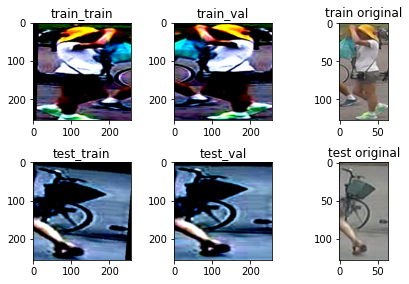

In [ ]:
def testing_setup():
  import matplotlib.pyplot as plt

  base, train = get_transformations()

  train_list=sorted(glob.glob(os.path.join(TRAIN_PATH, "*.jpg")))
  test_list=sorted(glob.glob(os.path.join(TEST_PATH, "*.jpg")))

  image_train=Image.open(train_list[random.randint(0, len(train_list)-1)])
  image_test=Image.open(test_list[random.randint(0, len(test_list)-1)])
  image_train_train=train(image_train)
  image_train_val=base(image_train)
  image_test_train=train(image_test)
  image_test_val=base(image_test)
  
  f, axarr = plt.subplots(2,3)
  axarr[0,0].imshow(image_train_train.permute(1,2,0))
  axarr[0,0].title.set_text("train_train")
  axarr[0,1].imshow(image_train_val.permute(1,2,0))
  axarr[0,1].title.set_text("train_val")
  axarr[0,2].imshow(image_train)
  axarr[0,2].title.set_text("train original")
  axarr[1,0].imshow(image_test_train.permute(1,2,0))
  axarr[1,0].title.set_text("test_train")
  axarr[1,1].imshow(image_test_val.permute(1,2,0))
  axarr[1,1].title.set_text("test_val")
  axarr[1,2].imshow(image_test)
  axarr[1,2].title.set_text("test original")
  f.tight_layout(pad=0.9)

testing_setup()

## Classification Task: definition of neural networks, training and data visualization.

In [ ]:
class FeaturesExtractor(torch.nn.Module):
  """
    output: (F) -> (512)
  """
  def __init__(self, out_features = 512, norm=False):
    super(FeaturesExtractor, self).__init__()

    self.backbone = torchvision.models.resnet34(True)
    in_features = self.backbone.fc.in_features
    self.backbone.fc = torch.nn.Linear(in_features, out_features)
    
  def forward(self, x):
    x = self.backbone(x)
    return x

class LabelClassifier(torch.nn.Module):
  
  def __init__(self, in_features, out_classes, dropout_p = None):
    super(LabelClassifier, self).__init__()
    
    self.dropout_p = dropout_p
    if self.dropout_p is not None:
      self.drop = torch.nn.Dropout(self.dropout_p)
    self.classifier = torch.nn.Linear(in_features, out_classes)
    
  def forward(self, x):
    if self.dropout_p is not None:
      x = self.drop(x)
    x = self.classifier(x)
    return x

class Classifiers(torch.nn.ModuleDict):
  def __init__(self, in_features=512, dropout_p=None):
    super(Classifiers, self).__init__()
    classifiers=dict()
    for label in MarketClassifier.labels:
      classes=2
      if label=="age":
        classes=4
      elif label=="downcolor":
        classes=10
      elif label=="upcolor":
        classes=9
      classifiers[label]=LabelClassifier(in_features, classes, dropout_p)

    self.classifiers = torch.nn.ModuleDict(classifiers)

  def forward(self, x):
    outputs=dict()
    for label in MarketClassifier.labels:
      outputs[label]=self.classifiers[label](x)
    return outputs

class MarketClassifier(torch.nn.Module):
  labels = [x for x in MarketDataset.dataset_labels] #The colors are classified as int

  def __init__(self, norm = False, dropout_p = None):
    super(MarketClassifier, self).__init__()
    self.norm = norm
    self.dropout_p = dropout_p

    extractor_features = 512
    self.extractor = FeaturesExtractor(out_features=extractor_features, norm=self.norm)
    self.classifiers = Classifiers(in_features=extractor_features, dropout_p=self.dropout_p)

  def forward(self, x):
    x = self.extractor(x)
    x = self.classifiers(x)
    return x

  def loss_function(outputs, targets):
    label_predictions = outputs
    label_targets = targets
    label_losses = list()

    for label, prediction in label_predictions.items():
      label_losses.append(F.cross_entropy(prediction, label_targets[label]))

    total_loss = sum(label_losses)
    return total_loss

  def optimizer(self, learning_rate, decay, momentum):
    opti = torch.optim.SGD(self.parameters(),learning_rate,momentum,0,decay)
    return opti


Train and test functions

In [ ]:
def train_classifier(network, data_loader, optimizer, cost_function, device = "cuda:0"):
  samples = 0
  cumulative_loss = 0.
  cumulative_accuracy = dict()
  for label in MarketClassifier.labels:
    cumulative_accuracy[label]=0.0

  network.train()
  for batch_index, (inputs, labels) in enumerate(data_loader):

    inputs = inputs.to(device)
    for label, target in labels.items():
      labels[label] = target.to(device)
    
    outputs = network(inputs)
    
    loss = cost_function(outputs, labels)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    for label in MarketClassifier.labels:
      _, predicted = outputs[label].max(1)
      cumulative_accuracy[label] += predicted.eq(labels[label]).sum().item()

  for label in MarketClassifier.labels:
    cumulative_accuracy[label]=cumulative_accuracy[label]/samples*100  

  return cumulative_loss/samples, cumulative_accuracy

def test_classifier(network, data_loader, cost_function, device = "cuda:0"):
  samples = 0
  cumulative_loss = 0.
  cumulative_accuracy=dict()
  for label in MarketClassifier.labels:
    cumulative_accuracy[label]=0.0

  network.eval()
  with torch.no_grad():
    for batch_index, (inputs, labels) in enumerate(data_loader):
      inputs = inputs.to(device)
      for label, target in labels.items():
        labels[label] = target.to(device)
              
      outputs = network(inputs)

      loss = cost_function(outputs, labels)

      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      for label in MarketClassifier.labels:
        _, predicted = outputs[label].max(1)
        cumulative_accuracy[label] += predicted.eq(labels[label]).sum().item()

  for label in MarketClassifier.labels:
    cumulative_accuracy[label]=cumulative_accuracy[label]/samples*100

  return cumulative_loss/samples, cumulative_accuracy

Early Stopping implementation

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, path='checkpoint.pt', logs = True):
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.path = path
    self.logs = logs

  def __call__(self, val_loss, model):
    score = -val_loss
    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.logs:
        print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    if self.logs:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss
    if self.logs:
      print("Checkpoint saved.")

  def __bool__(self):
    return self.early_stop

Train a network

In [ ]:
def setup_log_writer(log_path, name = None):
  from datetime import datetime
  import pytz
  rome_tz = pytz.timezone('Europe/Rome')
  now = datetime.now(rome_tz)
  now = now.strftime("%d/%m/%Y_%H:%M:%S")
  log_path = LOG_PATH_MARKET if log_path is None else log_path
  log_path += "/" + now
  if name is not None and name != "":
    log_path += " "+name
  writer = SummaryWriter(log_dir=log_path)
  return writer

def write_logs_classifier(writer, train_loss, train_accuracy, val_loss, val_accuracy, iteration):
  print("Iteration:", iteration)
  writer.add_scalar('Loss/train_loss', train_loss, iteration)
  writer.add_scalar('Loss/val_loss', val_loss, iteration)
  train_mean_accuracy=0.0
  val_mean_accuracy=0.0
  for label in MarketClassifier.labels:
    train_mean_accuracy+=train_accuracy[label]
    val_mean_accuracy+=val_accuracy[label]
    writer.add_scalar('Train Accuracy/'+label, train_accuracy[label], iteration)
    writer.add_scalar('Validation Accuracy/'+label, val_accuracy[label], iteration)
  
  train_mean_accuracy/=len(MarketClassifier.labels)
  val_mean_accuracy/=len(MarketClassifier.labels)
  writer.add_scalar('Train Accuracy/AVG', train_mean_accuracy, iteration)
  writer.add_scalar('Validation Accuracy/AVG', val_mean_accuracy, iteration)

  print('\t Training loss {:.5f}, Mean Training accuracy {:.2f}'.format(train_loss, train_mean_accuracy))
  print('\t Training accuracy {}'.format( train_accuracy))
  print('\t Validation loss {:.5f}, Mean Validation accuracy {:.2f}'.format(val_loss, val_mean_accuracy))
  print('\t Validation accuracy {}'.format(val_accuracy))

def execute_classifier(batch_size= 64, 
         device = 'cuda:0',
         learning_rate=0.001,
         weight_decay=0.00001, 
         momentum=0.8,
         epochs=10, 
         norm=True,
         dropout_p=0.5,
         log_path=None,
         name=None):
  
  writer = setup_log_writer(log_path, name)

  train_loader, val_loader, training_set, validation_set = get_data(batch_size=batch_size)

  net = MarketClassifier(norm=norm, dropout_p=dropout_p).to(device)
  
  optimizer = MarketClassifier.optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = MarketClassifier.loss_function

  early_stop_checkpoint_path = "/content/logs/market/early_stopping_checkpoint.pth"
  early_stopping = EarlyStopping(delta=0.0001, path=early_stop_checkpoint_path)

  print('Before training:')
  train_loss, train_accuracy = test_classifier(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test_classifier(net, val_loader, cost_function, device)
  write_logs_classifier(writer, train_loss, train_accuracy, val_loss, val_accuracy, 0)
  print("Training:")
  for e in range(epochs):
    train_loss, train_accuracy = train_classifier(net, train_loader, optimizer, cost_function, device)
    val_loss, val_accuracy = test_classifier(net, val_loader, cost_function, device)
    write_logs_classifier(writer,train_loss, train_accuracy, val_loss, val_accuracy, e+1)

    early_stopping(val_loss, net)
    if(early_stopping):
      print("Early stop triggered")
      break

  net.load_state_dict(torch.load(early_stop_checkpoint_path))

  print('After training:')
  train_loss, train_accuracy = test_classifier(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test_classifier(net, val_loader, cost_function, device)
  write_logs_classifier(writer,train_loss, train_accuracy, val_loss, val_accuracy, e+2)

  writer.close()
  return net, (training_set, validation_set)


def predict(net, device="cuda:0", transforms=None, filename="test.csv"):
  """
  Given a trained network and the images, this function computes the inferred values for the images.
  :param torch.nn.Module net: The trained network to be used.
  :param str dir_path: The directory path containing the images.
  :param str device: The device onto which to run the network.
  :param torchvision.transforms.transforms transforms: The possible transformations to be applied to the images.
  :param int num: The number of images to be taken from the directory. If 0 all the images are considered.
  :param str filename: The file name of the CSV file in which to write the predicted labels.
  :param bool file: If True, dir_path is the directory to a file. In this case please use .jpg at the end.
  """
  net.to(device)
  paths=list()

  data_loader = get_data(batch_size=1, data_path=TEST_PATH ,test=True)
  predictions=list() 
  net.eval()
  with torch.no_grad():
    for batch_index, (inputs, path) in enumerate(data_loader):
      inputs = inputs.to(device)             
      output = net(inputs)    
      predictions.append(MarketDataset.get_predictions(output, path[0]))
  MarketDataset.format_predictions(predictions, filename)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="{LOG_PATH_MARKET}"

In [ ]:
#TRAIN FEATURE EXTRACTOR AND CLASSIFIERS NETWORKS
network,sets = execute_classifier(name="Paced Learning", learning_rate=0.0001,epochs=100)
#SAVE THE AGGREGATOR NETWORK 
torch.save(network.state_dict(), SAVE_PATH_CLASSIFIER)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Before training:
Iteration: 0
	 Training loss 0.19133, Mean Training accuracy 47.41
	 Training accuracy {'age': 11.530235271242466, 'backpack': 72.84658759478904, 'bag': 62.52187439237799, 'handbag': 84.67820338323936, 'clothes': 82.94769589733619, 'down': 52.87769784172662, 'up': 44.81819949445849, 'hair': 40.29749173634066, 'hat': 51.23468792533541, 'gender': 49.82500486097609, 'upcolor': 7.427571456348435, 'downcolor': 7.884503208244216}
	 Validation loss 0.19350, Mean Validation accuracy 48.19
	 Validation accuracy {'age': 12.430632630410656, 'backpack': 76.84054753977063, 'bag': 64.33592304846468, 'handbag': 83.98076211616721, 'clothes': 85.46059933407325, 'down': 52.978172401035884, 'up': 44.72807991120977, 'hair': 39.289678135405104, 'hat': 51.128375878653344, 'gender': 49.574546799852016, 'upcolor': 8.065112837587865, 'downcolor': 9.470958194598595}
Training:
Iteration: 1
	 Training loss 0.15348, Mean Training accuracy 66.34
	 Training accuracy {'age': 77.18257826171495, 'backp

## Classification Task: production of deliverables

In [ ]:
#LOAD THE CLASSIFIER NETORK 
network = MarketClassifier().to("cuda:0")
network.load_state_dict(torch.load(LOAD_PATH_CLASSIFIER))

<All keys matched successfully>

In [ ]:
#WRITE LABELS PREDICTIONS OF FEATURE EXTRACTOR AND CLASSIFIERS NETWORKS
predict(network, filename=CLASSIFICATION_TEST_PATH)

# Person Re-Identification



## Person Re-Identification Task: definition of neural networks and training.

In [ ]:
class SimpleImageDataset(torch.utils.data.Dataset):
  def __init__(self, samples_paths, transformation=None):
    super(SimpleImageDataset, self).__init__()
    self.samples_paths = samples_paths
    self.transformation = transformation
  
  def __len__(self):
    return len(self.samples_paths)
  
  def __getitem__(self, idx):
    path = self.samples_paths[idx]
    image = Image.open(path)
    if self.transformation is not None:
      image = self.transformation(image)
    else:
      convert_tensor = T.ToTensor()
      image=convert_tensor(image)
    return image, path

class AggregatorDataset(torch.utils.data.Dataset):
  def Build(identities, folder_path, transformation=None):
    samples = dict()
    for id in sorted(identities):
      samples[id] = list()
    file_paths = sorted(glob.glob(os.path.join(folder_path,"*.jpg")))
    for file_path in file_paths:
      id = AggregatorDataset._id_from_path(file_path)
      if id in samples.keys():
        samples[id].append(file_path)

    dataset = list()
    for id, sample in samples.items():
      dataset.append(sample)
    return AggregatorDataset(dataset, transformation)

  def __init__(self, samples_paths, transformation=None):
    super(AggregatorDataset, self).__init__()
    self.samples_paths = samples_paths
    self.transformation = transformation

  def __len__(self):
    return len(self.samples_paths)
  
  def __getitem__(self, idx):    
    samples_list = self.samples_paths[idx]
    ids_sample = [i for i in range(len(samples_list))]

    anchor = random.choice(ids_sample)
    ids_sample.remove(anchor)
    positive = random.choice(ids_sample)

    identities = [i for i in range(len(self.samples_paths))]
    identities.remove(idx)

    negative_id = random.choice(identities)
    negative_list = [i for i in range(len(self.samples_paths[negative_id]))]
    negative = random.choice(negative_list)

    anchor_path = self.samples_paths[idx][anchor]
    anchor_image = Image.open(anchor_path)

    positive_path = self.samples_paths[idx][positive]
    positive_image = Image.open(positive_path)

    negative_path = self.samples_paths[negative_id][negative]
    negative_image = Image.open(negative_path)
    
    if self.transformation is not None:
      anchor_image = self.transformation(anchor_image)
      positive_image = self.transformation(positive_image)
      negative_image = self.transformation(negative_image)
    else:
      convert_tensor = T.ToTensor()
      anchor_image = convert_tensor(anchor_image)
      positive_image = convert_tensor(positive_image)
      negative_image = convert_tensor(negative_image)
    
    return (anchor_image,anchor_path), (positive_image,positive_path), (negative_image,negative_path)
  
  def _ids(folder_path):
    file_paths = sorted(glob.glob(os.path.join(folder_path,"*.jpg")))
    ids = set()
    for file_path in file_paths:
      ids.add(AggregatorDataset._id_from_path(file_path))
    return ids
  
  def _id_from_path(sample_path):
    id = int(sample_path.split('/')[-1].split('.')[0].split('_')[0])
    return id

class Aggregator(torch.nn.Module):

  class AggregatorModule(torch.nn.Module):
    def __init__(self, in_features, out_features, norm = False, dropout_p = 0.5):
      super(Aggregator.AggregatorModule, self).__init__()

      dropout_p=0.3     
      #features = in_features
      layers = list()

      if norm:
        layers.append(torch.nn.BatchNorm1d(in_features))
      layers.append(torch.nn.Linear(in_features=in_features,out_features=out_features))
      layers.append(torch.nn.Dropout(dropout_p))

      self.linears = torch.nn.ModuleList(layers)

    def forward(self, x):
      for i in range(len(self.linears)):
        x = self.linears[i](x)
      return x

  def __init__(self, out_features = 128, extractor_features = 512, norm = False, dropout_p = 0.5):
    super(Aggregator, self).__init__()
    self.norm = norm
    self.dropout_p = dropout_p

    self.extractor_features = extractor_features
    self.labels_features = 10 + 9 + 4 + 2 * 9
    self.out_features = out_features
    self._update()

  def forward(self, x):
    x = self.feature_extractor(x)
    labels_classification = self.label_classifier(x)

    labels_features = [output for label, output in labels_classification.items()]
    labels_features = torch.cat(labels_features,1)

    x = torch.cat([x, labels_features], 1)
    
    x = self.aggregator(x)
    return x

  def _update(self, new_label_classifier=None, new_feature_extractor=None, new_aggregator=None):
    # this function is needed in case we want to train separately the networks
    
    if new_label_classifier is not None:
      self.label_classifier = new_label_classifier
    else:
      self.label_classifier = Classifiers(self.extractor_features, self.dropout_p)

    if new_feature_extractor is not None:
      self.feature_extractor = new_feature_extractor
    else:
      self.feature_extractor = FeaturesExtractor(self.extractor_features,self.norm)
    
    if new_aggregator is not None:
      self.aggregator = new_aggregator
    else:
      combined = self.extractor_features + self.labels_features
      self.aggregator = Aggregator.AggregatorModule(combined, self.out_features, self.norm, self.dropout_p)

  def LossFunction(anchor, positive, negative):
    triplet = torch.nn.TripletMarginLoss()
    loss = triplet(anchor, positive, negative)
    return loss
  
  def optimizer(self, learning_rate, decay, momentum):
    opti = torch.optim.SGD(self.parameters(),learning_rate,momentum,0,decay)
    return opti
  
  def Distance(a, b):
    """
    Given an array a of size [BatchA,N] and an array b of size [BatchB,N]
    compute the distance matrix between the two groups of points
    """
    assert a.size()[1] == b.size()[1], "The points must have the same length"
    # let's simply use the euclidian distance
    return torch.cdist(a, b)

In [ ]:
def write_logs_aggregator(writer, train_loss, train_mean_distance, val_loss, val_mean_distance, iteration):
  print("Iteration:", iteration)
  writer.add_scalar('Loss/train_loss', train_loss, iteration)
  writer.add_scalar('Loss/val_loss', val_loss, iteration)
  writer.add_scalar('Mean Distance/train', train_mean_distance, iteration)
  writer.add_scalar('Mean Distance/validation', val_mean_distance, iteration)

  print('\t Training loss {:.5f}, Mean Training Distance {:.2f}'.format(train_loss, train_mean_distance))
  print('\t Validation loss {:.5f}, Mean Validation Distance {:.2f}'.format(val_loss, val_mean_distance))

def test_aggregator(model, loader, device='cuda:0'):
  model.to(device)
  samples = 0
  cumulative_loss = 0.
  cumulative_distance = 0.

  model.eval()
  with torch.no_grad():
    for batch_idx, (anchor, positive, negative) in enumerate(loader):
      
      anchor_image = anchor[0].to(device)
      positive_image = positive[0].to(device)
      negative_image = negative[0].to(device)
        
      anchor_output = model(anchor_image)
      positive_output = model(positive_image)
      negative_output = model(negative_image)
      
      loss = Aggregator.LossFunction(anchor_output, positive_output, negative_output)

      samples += anchor_image.shape[0]
      cumulative_loss += loss.item()
      distances = Aggregator.Distance(anchor_output, negative_output)
      mean_distances = torch.mean(distances, 1)
      cumulative_distance += torch.sum(mean_distances).item()
      
  return cumulative_loss/samples, (cumulative_distance/samples)

def train_aggregator(model, loader, optimizer, device='cuda:0'):
  model.to(device)
  samples = 0
  cumulative_loss = 0.
  cumulative_distance = 0.

  model.train()
  for batch_idx, (anchor, positive, negative) in enumerate(loader):
    anchor_image = anchor[0].to(device)
    positive_image = positive[0].to(device)
    negative_image = negative[0].to(device)
      
    anchor_output = model(anchor_image)
    positive_output = model(positive_image)
    negative_output = model(negative_image)

    loss = Aggregator.LossFunction(anchor_output, positive_output, negative_output)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    samples += anchor_image.shape[0]
    cumulative_loss += loss.item()

    #shape = [batch x batch]
    distances = Aggregator.Distance(anchor_output, negative_output)
    #shape = [batch]
    mean_distances = torch.mean(distances, 1)

    cumulative_distance += torch.sum(mean_distances).item()
  
  
  return cumulative_loss/samples, (cumulative_distance/samples)

def get_data_aggregator(batch_size = 64, workers = 2, data_path=TRAIN_PATH):
  training_set, validation_set = subdivide_train_val_samples(data_path, ratio=0.5)

  base_transforms, train_stransforms = get_transformations()
  training_dataset = AggregatorDataset.Build(training_set, data_path)
  validation_dataset = AggregatorDataset.Build(validation_set, data_path)

  train_loader = torch.utils.data.DataLoader(training_dataset, batch_size, True, num_workers=workers)
  val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size, True, num_workers=workers)

  return train_loader, val_loader

def execute_aggregator(market,
         batch_size=64,
         device = 'cuda:0',
         learning_rate=0.001, 
         weight_decay=0.000001, 
         momentum=0.9,
         epochs=10, 
         norm=True,
         name=None):

  writer = setup_log_writer(log_path=LOG_PATH_AGGREGATOR,name=name)

  train_loader, val_loader = get_data_aggregator(batch_size)

  net = Aggregator(norm=norm).to(device)

  market.to(device)
  net._update(new_label_classifier=market.classifiers, new_feature_extractor=market.extractor)
  
  optimizer = net.optimizer(learning_rate, weight_decay, momentum)

  early_stop_checkpoint_path = "/content/logs/aggregator/early_stopping_checkpoint.pth"
  early_stopping = EarlyStopping(patience=30, delta=0.00001, path=early_stop_checkpoint_path)

  print('Before training:')
  train_loss, train_mean_distance = test_aggregator(net, train_loader, device)
  val_loss, val_mean_distance = test_aggregator(net, val_loader, device)
  write_logs_aggregator(writer, train_loss, train_mean_distance, val_loss, val_mean_distance, 0)

  print("Training:")
  for e in range(epochs):
    train_loss, train_mean_distance = train_aggregator(net, train_loader, optimizer, device)
    val_loss, val_mean_distance = test_aggregator(net, val_loader, device)
    write_logs_aggregator(writer, train_loss, train_mean_distance, val_loss, val_mean_distance, e+1)

    early_stopping(val_loss, net)
    if(early_stopping):
      print("Early stop triggered")
      print("")
      break
    print("")

  net.load_state_dict(torch.load(early_stop_checkpoint_path))

  print('After training:')
  train_loss, train_mean_distance = test_aggregator(net, train_loader, device)
  val_loss, val_mean_distance = test_aggregator(net, val_loader, device)
  write_logs_aggregator(writer, train_loss, train_mean_distance, val_loss, val_mean_distance, e+2)
  print('-----------------------------------------------------')

  writer.close()
  return net

In [ ]:
def im_name(image_path):
  name = image_path.split('/')[-1]
  return name

def measure_distances(model, query_data, test_data, ground_truth_querys, threshold, TRAIN_MODE, batch_size=32, workers=2, device="cuda:0"):
  model.to(device)
  model.eval()
  writer = SummaryWriter(LOG_DISTANCE_MEASUREMENT_AGGREGATOR)

  query_dataset = SimpleImageDataset(query_data)#, image_val_transform())
  test_dataset = SimpleImageDataset(test_data)#, image_val_transform())

  query_loader = torch.utils.data.DataLoader(query_dataset,batch_size,num_workers=workers)
  test_loader = torch.utils.data.DataLoader(test_dataset,batch_size,num_workers=workers)

  query_images_features = list()
  test_images_features = list()
  ##########################################################################################

  for batch_idx_query, (images_query, paths_query) in enumerate(query_loader):
    images_query = images_query.to(device)
    output_query = model(images_query)

    for batch_idx_test, (images_test, paths_test) in enumerate(test_loader):
      images_test = images_test.to(device)
      output_test = model(images_test)
      
      distance_matrix_new = Aggregator.Distance(output_query, output_test)
      
      distance_matrix_new = distance_matrix_new.cpu().detach().numpy()
      if batch_idx_test>0:
        distance_matrix = np.concatenate((distance_matrix, distance_matrix_new), axis = 1) # distance_matrix + distance_matrix_new
      else:
        distance_matrix = distance_matrix_new
      
    if batch_idx_query>0:
      distance_matrix_all_query = np.concatenate((distance_matrix_all_query, distance_matrix), axis = 0)
    else:
      distance_matrix_all_query = distance_matrix 
    print(distance_matrix_all_query.shape)
    print(batch_idx_query)
    
    
  
  #distance between each image of query_images_features and each image of test_images_features
  distance_matrix = distance_matrix_all_query.tolist()
  ##########################################################################################
  if TRAIN_MODE==True:
    for threshold in np.arange(5, 15, 0.1):
      query_results = dict()
      for i in range(len(distance_matrix)):
        query_results[query_data[i]] = get_ordered_dict(distance_matrix[i], test_data, threshold)
      m_ap = Evaluator.evaluate_map(query_results, ground_truth_querys)
      print("THRESHOLD", threshold)
      print(m_ap)
      print("\n")
  else:
    query_results = dict()
    for i in range(len(distance_matrix)):
      query_results[query_data[i]] = get_ordered_dict(distance_matrix[i], test_data, threshold)
  return query_results
  
def get_ordered_dict(values, paths, threshold):
  table = dict()
  for i in range(len(values)):
    table[paths[i]] = values[i]
  table = dict(sorted(table.items(), key=lambda x: x[1]))
  table = {key : val for key, val in table.items() if not (isinstance(val, float) and (val > threshold))}
  return table



In [ ]:
def get_result_line(query_image, test_images):
  query_name = im_name(query_image)
  test_names = list()
  for test_image, result in test_images.items():
    test_names.append(im_name(test_image))

  line = "{}: {}\n".format(query_name, ", ".join(test_names))
  return line

def print_result_file(results, file_name = REID_TEST_PATH):
  with open(file_name, "w") as result_file:
    for query, tests in results.items():
      line = get_result_line(query, tests)
      print(line)
      result_file.write(line)



In [ ]:
def get_identities_for_aggregator(samples_path="", files=[]):
  """Extracts a set of ids from a list of paths.
  :param str samples_path: The directory containing the images.
  :param list files: The list of file names.
  :return set: A set of ids.
  """
  assert (bool(samples_path!="") ^ bool(files!=[])), "One and only one of the two parameters must be set."
  file_paths=files
  if samples_path!="":
    file_paths = sorted(glob.glob(os.path.join(samples_path,"*.jpg")))
  ids_set = set()
  for file_path in file_paths:
    ids_set.add(get_identity(file_path))
  ids_list = list()
  for file_path in file_paths:
    ids_list.append(get_identity(file_path))
  return file_paths, ids_set, ids_list 
  
def create_ground_truth_querys(data_path, ratio = 0.8, shuffle = True):

  file_paths, ids_set, ids_list = get_identities_for_aggregator(data_path)
  ground_truth_querys = dict()
  for i in ids_set:
    index = list(np.where(np.array(ids_list)==i)[0])
    ind_key = index.pop(random.randint(0,len(index)-1))
    ground_truth_querys[file_paths[ind_key]]= list(np.array(file_paths)[index])

  return ground_truth_querys

In [ ]:
class Evaluator:

    @staticmethod
    def evaluate_map(predictions, ground_truth):
        '''
        Computes the mAP (https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173) of the predictions with respect to the given ground truth
        In person reidentification mAP refers to the mean of the AP over all queries.
        The AP for a query is the area under the precision-recall curve obtained from the list of predictions considering the
        ground truth elements as positives and the other ones as negatives

        :param predictions: dictionary from query filename to list of test image filenames associated with the query ordered
                            from the most to the least confident prediction.
                            Represents the predictions to be evaluated.
        :param ground_truth: dictionary from query filename to set of test image filenames associated with the query
                             Represents the ground truth on which to evaluate predictions.

        :return:
        '''

        m_ap = 0.0
        for current_ground_truth_query, current_ground_truth_query_set in ground_truth.items():

            # No predictions were performed for the current query, AP = 0
            if not current_ground_truth_query in predictions:
                continue

            current_ap = 0.0  # The area under the curve for the current sample
            current_predictions_list = predictions[current_ground_truth_query]

            # Recall increments of this quantity each time a new correct prediction is encountered in the prediction list
            delta_recall = 1.0 / len(current_ground_truth_query_set)

            # Goes through the list of predictions
            encountered_positives = 0
            for idx, current_prediction in enumerate(current_predictions_list):
                # Each time a positive is encountered, compute the current precision and the area under the curve
                # since the last positive
                if current_prediction in current_ground_truth_query_set:
                    encountered_positives += 1
                    current_precision = encountered_positives / (idx + 1)
                    current_ap += current_precision * delta_recall

            m_ap += current_ap

        # Compute mean over all queries
        m_ap /= len(ground_truth)

        return m_ap

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="{LOG_PATH_AGGREGATOR}"

In [ ]:
#TRAIN AGGREGATOR NETWORK
LOAD_CLASSIFIER = True
if LOAD_CLASSIFIER == True:
  market = MarketClassifier().to("cuda:0")
  market.load_state_dict(torch.load(LOAD_PATH_CLASSIFIER))
  market.to("cuda:0")
agg = execute_aggregator(market, batch_size=32, epochs=200)
#SAVE THE AGGREGATOR NETWORK 
torch.save(agg.state_dict(), SAVE_PATH_AGGREGATOR)

Before training:
Iteration: 0
	 Training loss 0.00664, Mean Training Distance 4.64
	 Validation loss 0.00855, Mean Validation Distance 4.67
Training:
Iteration: 1
	 Training loss 0.01470, Mean Training Distance 6.84
	 Validation loss 0.00757, Mean Validation Distance 5.45
Validation loss decreased (inf --> 0.007565).  Saving model ...
Checkpoint saved.

Iteration: 2
	 Training loss 0.01246, Mean Training Distance 7.21
	 Validation loss 0.00566, Mean Validation Distance 5.88
Validation loss decreased (0.007565 --> 0.005657).  Saving model ...
Checkpoint saved.

Iteration: 3
	 Training loss 0.00999, Mean Training Distance 7.77
	 Validation loss 0.00597, Mean Validation Distance 6.11
EarlyStopping counter: 1 out of 30

Iteration: 4
	 Training loss 0.00944, Mean Training Distance 8.26
	 Validation loss 0.00484, Mean Validation Distance 6.76
Validation loss decreased (0.005657 --> 0.004841).  Saving model ...
Checkpoint saved.

Iteration: 5
	 Training loss 0.00773, Mean Training Distance 8.

In [ ]:
#LOAD THE AGGREGATOR NETORK 
agg = Aggregator(norm=True).to("cuda:0")
agg.load_state_dict(torch.load(LOAD_PATH_AGGREGATOR))

agg._update(new_label_classifier=agg.label_classifier, new_feature_extractor=agg.feature_extractor, new_aggregator=agg.aggregator)

In [ ]:
#WRITE PREDIICTIONS OF AGGREGATOR NETWORK
#TRAIN_MODE = True only if we want to valuate the preformance of our aggregator to choose the value of the threshold on the base of the mAP
TRAIN_MODE = True
#The best value of threshold obtained in the TRAIN MODE
threshold = 13


if TRAIN_MODE == False:
  query_paths = file_paths = sorted(glob.glob(os.path.join(QUERIES_PATH,"*.jpg")))
  test_paths = file_paths = sorted(glob.glob(os.path.join(TEST_PATH,"*.jpg")))

  results = measure_distances(agg, query_paths, test_paths, [], threshold, TRAIN_MODE, device="cuda:0")
  print_result_file(results)
else:
  ground_truth_querys = create_ground_truth_querys(TRAIN_PATH)
  query_paths = list(ground_truth_querys.keys())
  test_paths = list(ground_truth_querys.values())
  test_paths  = [val for sublist in test_paths for val in sublist]

  results = measure_distances(agg, query_paths[:], test_paths[:], ground_truth_querys, threshold, TRAIN_MODE, device="cuda:0")